# Inversions with okapy and SciPy

A simple inversion making use of the Powell algorithm built into the scipy.optimize.minimize function, the Okada model in okapy and our downsampled data in 'okinv' format to try to obtain a best-fitting model of an earthquake.

## Set it up! 

Let's start with some dependencies:

In [12]:
from okapy import rect_shear_fault, los_penalty_fault
from math import sin, cos, tan, radians, floor
from matplotlib import cm, colors
from scipy.optimize import minimize, Bounds
import numpy as np
import matplotlib.pyplot as plt

## Defining the data, model parameters and elastic constants

Load in the downsampled interfrogram data:

In [13]:
# let's try to make a list!
data = list()
datanames = list()

# load in a data file (need to copy this block for each data file)
# add the full path to the data file here:
indata = np.loadtxt('./pishan_asc.okinv', 
                    usecols=(0,1,2,3,4,5))
indata[:,0]*=1000  # convert x coord from km to m
indata[:,1]*=1000  # convert y coord from km to m
data.append(indata)
dataname = 'Pishan ascending'
datanames.append(dataname)

# load in a data file (need to copy this block for each data file)
# add the full path to the data file here:
indata = np.loadtxt('./pishan_dsc.okinv', 
                    usecols=(0,1,2,3,4,5))
indata[:,0]*=1000  # convert x coord from km to m
indata[:,1]*=1000  # convert y coord from km to m
data.append(indata)
dataname = 'Pishan descending'
datanames.append(dataname)

Let's specify some parameters for our models: starting guesses and uncertainties

In [34]:
# for each quantity, starting guess is the first value, sigma the second
strike = [105, 10]        # in degrees
dip = [24, 10]           # in degrees
rake = [60, 20]           # in degrees
slip = [.4, 0.75]          # in m
xs = [775000, 5000]        # x coord of center of updip fault projection, in m 
ys = [4170000, 5000]       # y coord of same, in m
as_length = [15000, 2000]     # along-strike fault length, in m
top_depth = [2500, 2000]      # depth of top edge of fault, in m
bottom_depth = [7000, 5000]  # depth to bottom edge of fault

fpstart = np.array([strike[0], dip[0], rake[0], slip[0], xs[0], ys[0], as_length[0], top_depth[0], bottom_depth[0]])
fpsigma = np.array([strike[1], dip[1], rake[1], slip[1], xs[1], ys[1], as_length[1], top_depth[1], bottom_depth[1]])

# let's calculate some 2-sigma bounds on these starting values:
fplowb = fpstart-2*fpsigma
fphighb = fpstart+2*fpsigma

# find a random starting model (assume flat pdf between lower and upper bounds)
fparams_restart = fpstart + np.multiply(((np.random.random_sample(9)*4)-2),fpsigma)

# sanity check of depths (make sure bottom depth is greater than top depth)
if fparams_restart[7] > fparams_restart[8]:
    bottom = fparams_restart[7]
    fparams_restart[7] = fparams_restart[8] 
    fparams_restart[8] = bottom
    
# and output the starting model    
print("example starting fault parameters:")
print('  strike:',fparams_restart[0],'dip:',fparams_restart[1],'rake:',fparams_restart[2],'slip:',fparams_restart[3])
print('  xs:',fparams_restart[4],'ys:',fparams_restart[5])
print('  length:',fparams_restart[6],'top:',fparams_restart[7],'bottom:',fparams_restart[8])

example starting fault parameters:
  strike: 124.85643912708753 dip: 4.368964698353228 rake: 24.18240224262022 slip: 1.0674438274223028
  xs: 768787.8494566671 ys: 4178200.3468545806
  length: 15322.925194741074 top: 1650.964380526787 bottom: 4030.0427957010124


Finally, let's define some elastic parameters, using some standard values:

In [4]:
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Evaluating the penalty function for a random starting model

We now have all the elements we need to calculate an initial penalty value, using the los_penalty_fault function in okapy. This function has the following syntax: 

<center>penalty=los_penalty_fault(fparams, eparams, data)</center>

The output argument, 'penalty' is the total squared misfit of the model to the data, accounting for a zero-level shift.

There are three input arguments, for which we have already seen examples. 'fparams' is a vector of fault parameters, of the type we have already seen (e.g. fstart, fparams_restart), 'eparams' contains elastic constants, and 'data' is a matrix of data point locations, values and line-of-sight parameters. (You may recognize that these are the same inputs that we used to compute our forward model displacements in the forward modeling notebook...)

For example, we can evaluate the penalty function for our starting model:

In [5]:
init_penalty = los_penalty_fault(fparams_restart, eparams, data)

print('initial penalty:',init_penalty, 'm^2')

initial penalty: 0.4868113974050355 m^2


## Optimizing fault parameters using the Powell algorithm in SciPy

The <a href="https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize">'optimize.minimize'</a> function in SciPy is a very flexible optimization package that can apply several different optimization algorithms to the problem of minimizing a specified nonlinear function. Here we want to find the parameter values that minimize our penalty function, 'los_penalty_fault'.

We will make use of the <a href="https://en.wikipedia.org/wiki/Powell%27s_method">Powell algorithm</a>, which is a 'direction set' minimization algorithm that, in our experience, works well for these sorts of problems. It allows us to specify bounds on the inversion parameters, which is particularly useful for limiting the range of models it will test. The Powell algorithm also requires a starting guess, for which we will use our random starting model ('fparams_restart'). 

Note that our 'los_penalty_fault' function has three input arguments &ndash; the fault parameters, the elastic parameters and the data. We only want the Powell algorithm to vary the first of these (which it does by default), but we need to pass all three to properly evaluate the penalty. scipy.optimize allows us to pass the additional arguments to the penalty function using the 'args' option.

In [35]:
# the scipy.optimize way of setting bounds:
fpbounds = Bounds(fplowb,fphighb)

# and run the Powell algorithm minimizer! 
results = minimize(los_penalty_fault, fparams_restart, args=(eparams, data),  method='Powell', 
                   bounds=fpbounds)

We can look at the results of this optimization run, by printing the contents of 'results':

In [36]:
results

   direc: array([[ 7.01552410e-01, -3.68898504e-01,  1.46880982e+00,
        -2.57650029e-03,  4.09583710e+02,  2.27939481e+02,
         1.60731967e-03,  2.79271770e+01,  8.33638663e+01],
       [ 9.44512962e-01, -1.61350689e+00, -9.79721857e-01,
         4.28566271e-02, -1.00137947e+00,  2.26192018e+02,
         7.08261708e+00,  4.37840069e+02, -1.61010343e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.24338805e-03,  4.73458731e-03, -3.40356289e-02,
        -1.33851257e-04, -4.40943421e+00, -2.44236625e+00,
        -3.11065684e-04, -3.30743430e-03, -7.88199183e-01],
       [ 7.42339934e-01, -2.03873050e-01,  1.05039260e+00,
         2.87740235e-04,  2.63523137e+02,  1.85386640e+02,
         5.99483139e-02,  5.28699885e+01,  7.69184244e+01],
       [ 8.89177553e+00, -6.15341010e+00,  1.22217636e+01,
         6.17402619e-02,  2.77134153e+03,

Of these, 'direc' shows directions in parameter space that the algorithm took; 'fun' is the final, minimum value of the penalty function; 'nfev' is the number of penalty function evaluations (which might explain the delay in getting a result); 'nit' is the number of iterations (direction changes), and 'x' is the final set of fault parameters (that correspond to the minimum penalty, 'fun'). 

We can extract the values of interest here, and hopefully verify that the final penalty is smaller than the one we started with:  

In [37]:
fparams_out = results.x
output_penalty = results.fun

print("final fault parameters:")
print('  strike:',fparams_out[0],' dip:',fparams_out[1],' rake:',fparams_out[2],' slip:',fparams_out[3])
print('  xs:',fparams_out[4],' ys:',fparams_out[5])
print('  length:',fparams_out[6],' top:',fparams_out[7],' bottom:',fparams_out[8])
print('initial penalty:',init_penalty,'m^2  final penalty:',output_penalty,'m^2')

final fault parameters:
  strike: 115.38951484772674  dip: 23.021616907868253  rake: 95.84639054208478  slip: 0.4236760035188601
  xs: 776754.8535830362  ys: 4177155.2843097947
  length: 18999.99748931866  top: 6499.999984102703  bottom: 11320.481615535546
initial penalty: 0.4868113974050355 m^2  final penalty: 0.05917334068424774 m^2


## Local vs global minima

Technically, what our single run of the Powell algorithm has found is a 'local minimum' of the penalty function. For complicated functions, such as the penalty function of an Okada model fitted to InSAR data that contain noise (our situation!) it is usually the case that there are several, or perhaps many such minima. It's analous to finding the deepest point on the surface of the Moon, by always taking the steepest path downhill. Eventually, you will walk into a crater, and find your way to the bottom of it. But what if two craters over, there is a deeper one?

The problem of finding a 'global minimum' of the penalty function, corresponding to the best-fitting of all possible models, is not straightforward or exact. Following the crater analogy, it can be very dependent on your starting location &ndash; sometimes you need to start away from smaller holes in order to walk into bigger ones! Which is why, when we set up this optimization problem, we randomized our starting guess of the answer. You also have to be careful to specify solution bounds large enough that the neighborhood of the best answer is covered. 

By comparing your answer with your classmates' answers, which originated from different random starting guesses, within a fairly conservative set of bounds,  you should be able to see if there are smaller misfits out there. Or alternatively, if you don't want to crowdsource the problem, you could loop through a large number (say 100) of optimization runs with randomised starting guesses (you will often see these described as 'Monte Carlo restarts'), and retain the best models and penalties from each, in order to find a global minimum solution. 

Paste the best answer you can find here:

In [38]:
# manually set the best params here 
#best_fparams=[109.64893723811593, 24.234080268343902, 80.14205588151094, 0.5120726223037464,
              #776349.7676592212, 4176232.757013912, 18999.997383216163, 6499.992592779776,
              #10437.123989703368]
#best_penalty=0.33233488609765705

# alternatively, use results from our optinmization for best params and penalty 
best_fparams = results.x
best_penalty = results.fun

## Optional: looping to find the global minimum

If you don't have over 100 classmates to crowdsource the problem, the next best thing is to loop through a lot of optimizations from different starting models yourself, and select the model with the lowest penalty.

Shown here is one strategy for doing this. We make a variable for the best penalty function ('bestfun'), and initialize it with an extremely large number (if your penalties are bigger than this, your starting model has some problems!) Next, we loop through 100 model runs, and each time, select a new random starting model, run the optimization, compare the misfit to our best penalty function, and if it is better, we update bestfun with the new best penalty function, and also save the best fault parameters in an array ('bestparams'). At the end, bestparams should contain the best fault parameters that the optimization could find, and bestfun should have the best penalty. 

Obviously, this takes a lot longer than running the optimization once, so maybe you could try it in your spare time...

In [41]:
best_penalty=1e30

for i in range(100):

# find a random starting model (assume flat pdf between lower and upper bounds)
    fparams_restart = fpstart + np.multiply(((np.random.random_sample(9)*4)-2),fpsigma)

# sanity check of depths (make sure bottom depth is greater than top depth)
    if fparams_restart[7] > fparams_restart[8]:
        bottom = fparams_restart[7]
        fparams_restart[7] = fparams_restart[8] 
        fparams_restart[8] = bottom

# the scipy.optimize way of setting bounds:
    fpbounds = Bounds(fplowb,fphighb)

# and run the Powell algorithm minimizer! 
    results = minimize(los_penalty_fault, fparams_restart, args=(eparams, data),  method='Powell', 
                   bounds=fpbounds)

    # if we found a better model, save it!
    if results.fun<best_penalty:
        best_penalty=results.fun
        best_fparams = results.x
        
    print("run {0:d}, penalty: {1:f}, best penalty: {2:f}".format(i,results.fun,best_penalty)) 

run 0, penalty: 0.422367, best penalty: 0.422367
run 1, penalty: 0.066868, best penalty: 0.066868
run 2, penalty: 0.066123, best penalty: 0.066123
run 3, penalty: 0.056599, best penalty: 0.056599
run 4, penalty: 0.434837, best penalty: 0.056599
run 5, penalty: 0.432667, best penalty: 0.056599
run 6, penalty: 0.457711, best penalty: 0.056599
run 7, penalty: 0.058269, best penalty: 0.056599
run 8, penalty: 0.059552, best penalty: 0.056599
run 9, penalty: 0.066290, best penalty: 0.056599
run 10, penalty: 0.119104, best penalty: 0.056599
run 11, penalty: 0.061441, best penalty: 0.056599
run 12, penalty: 0.198684, best penalty: 0.056599


<ipython-input-41-963e2ce97b7c>:18: OptimizeWarning: Initial guess is not within the specified bounds
  results = minimize(los_penalty_fault, fparams_restart, args=(eparams, data),  method='Powell',


run 13, penalty: 0.123984, best penalty: 0.056599
run 14, penalty: 0.462858, best penalty: 0.056599
run 15, penalty: 0.055587, best penalty: 0.055587
run 16, penalty: 0.411405, best penalty: 0.055587
run 17, penalty: 0.088511, best penalty: 0.055587
run 18, penalty: 0.059266, best penalty: 0.055587
run 19, penalty: 0.056080, best penalty: 0.055587
run 20, penalty: 0.153505, best penalty: 0.055587
run 21, penalty: 0.448015, best penalty: 0.055587
run 22, penalty: 0.057156, best penalty: 0.055587
run 23, penalty: 0.056282, best penalty: 0.055587
run 24, penalty: 0.465631, best penalty: 0.055587
run 25, penalty: 0.088544, best penalty: 0.055587
run 26, penalty: 0.433586, best penalty: 0.055587
run 27, penalty: 0.151992, best penalty: 0.055587
run 28, penalty: 0.110047, best penalty: 0.055587
run 29, penalty: 0.066858, best penalty: 0.055587
run 30, penalty: 0.062356, best penalty: 0.055587
run 31, penalty: 0.063300, best penalty: 0.055587
run 32, penalty: 0.409033, best penalty: 0.055587


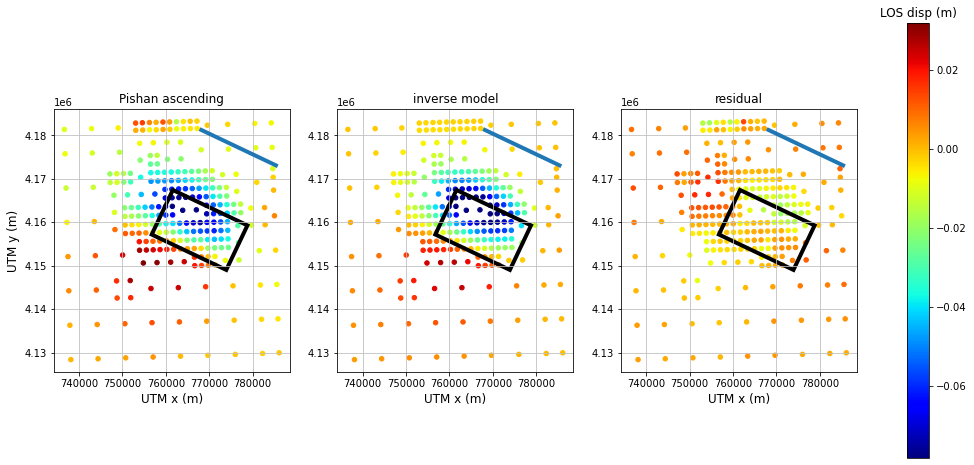

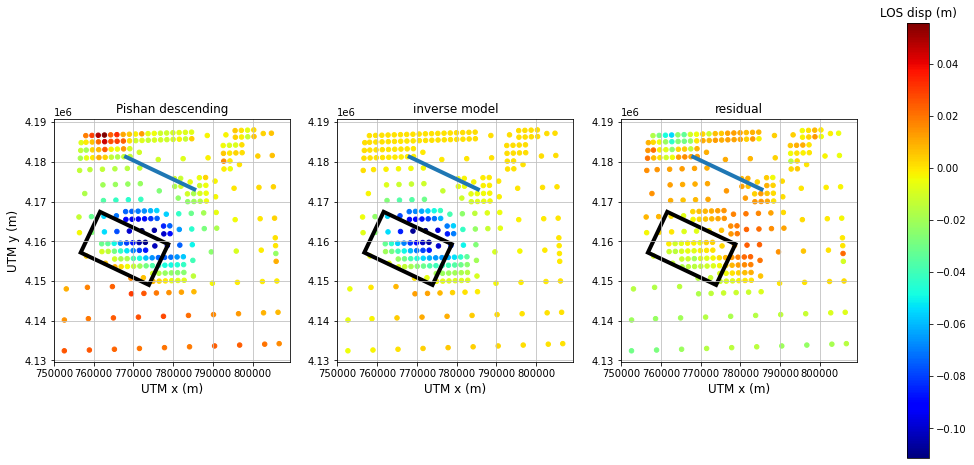

In [39]:
# Plot the 'best' model

# calculate the displacements
model_los_disps = rect_shear_fault(best_fparams, eparams, data)

# exteact fault location for plotting

#top of the fault
linex=[best_fparams[4]+(best_fparams[6]/2)*np.sin(np.radians(best_fparams[0])),
       best_fparams[4]-(best_fparams[6]/2)*np.sin(np.radians(best_fparams[0]))]
liney=[best_fparams[5]+(best_fparams[6]/2)*np.cos(np.radians(best_fparams[0])),
       best_fparams[5]-(best_fparams[6]/2)*np.cos(np.radians(best_fparams[0]))]

#top and bottom of the fault factors
r1=best_fparams[7]/np.tan(np.radians(best_fparams[1]))
r2=best_fparams[8]/np.tan(np.radians(best_fparams[1]))

#arrays for the fault shape
faultx=[linex[0]+r1*np.sin(np.radians(best_fparams[0]+90)), linex[0]+r2*np.sin(np.radians(best_fparams[0]+90)), 
        linex[1]+r2*np.sin(np.radians(best_fparams[0]+90)), linex[1]+r1*np.sin(np.radians(best_fparams[0]+90))]

faulty=[liney[0]+r1*np.cos(np.radians(best_fparams[0]+90)), liney[0]+r2*np.cos(np.radians(best_fparams[0]+90)), 
        liney[1]+r2*np.cos(np.radians(best_fparams[0]+90)), liney[1]+r1*np.cos(np.radians(best_fparams[0]+90))]

# parse the input data
ndset = len(data)

# loop through your datasets
for i in range(ndset):

    # grab yer data
    dataset=data[i]
    
    # calculate the mean residual
    zero_shift = np.mean(dataset[:,2]-model_los_disps[i])
    
    # calculate the residual without nuisances...
    shifted_data = dataset[:,2]-zero_shift
    residual_los_disps = model_los_disps[i]-shifted_data
    
    # color limits based on the shifted data
    cmin, cmax = shifted_data.min(), shifted_data.max()
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
    axlist = [ax1,ax2,ax3]   # handles for your subplots
    


    
    # FORWARD MODEL- scatter with colormap mapping to z value
    scat=ax1.scatter(dataset[:,0],dataset[:,1],s=20,c=shifted_data, 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    # add fault shape to forawrd model
    ax1.plot(linex,liney,linewidth=4)
    ax1.fill(faultx,faulty,linewidth=4,fill=False)
    #plot forward model
    ax1.set_xlabel("UTM x (m)",fontsize=12)
    ax1.set_ylabel("UTM y (m)",fontsize=12)
    ax1.title.set_text(datanames[i])
    ax1.grid(True,linestyle='-',color='0.75')
    ax1.set_aspect('equal')

    # INVERSE MODEL-scatter with colormap mapping to z value
    scat=ax2.scatter(dataset[:,0],dataset[:,1],s=20,c=model_los_disps[i], 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    #add fault shape to inverse model
    ax2.plot(linex,liney,linewidth=4)
    ax2.fill(faultx,faulty,linewidth=4,fill=False)
    #plot inverse modal 
    ax2.set_xlabel("UTM x (m)",fontsize=12)
    ax2.title.set_text('inverse model')
    ax2.grid(True,linestyle='-',color='0.75')
    ax2.set_aspect('equal')

    # RESIDAL MODEL-scatter with colormap mapping to z value
    scat=ax3.scatter(dataset[:,0],dataset[:,1],s=20,c=residual_los_disps, 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    #add on fault shape to the data graph
    ax3.plot(linex,liney,linewidth=4)
    ax3.fill(faultx,faulty,linewidth=4,fill=False)
    #plot it 
    ax3.set_xlabel("UTM x (m)",fontsize=12)
    ax3.title.set_text('residual')
    ax3.grid(True,linestyle='-',color='0.75')
    ax3.set_aspect('equal')

    clb=fig.colorbar(scat,ax=axlist)
    clb.ax.set_title('LOS disp (m)')
    plt.show();